<a href="https://colab.research.google.com/github/estebanbecerra/k_brazos_BFRRCE/blob/main/notebook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos UCB en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos UCB en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: Esteban Becerra, Carlos Cruzado, Anastasiya Ruzhytska
    Email: esteban.becerraf@um.es carlos.cruzadoe1@um.es anastasiya.r.r@um.es
    Date: 2025/02/16

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [1]:
#@title Copiar el repositorio.

!git clone https://github.com/estebanbecerra/k_brazos_BFRRCE.git
!cd k_brazos_BFRRCE/

Cloning into 'k_brazos_BFRRCE'...
remote: Enumerating objects: 324, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (162/162), done.
remote: Total 324 (delta 82), reused 0 (delta 0), pack-reused 161 (from 1)
Receiving objects: 100% (324/324), 7.84 MiB | 7.85 MiB/s, done.
Resolving deltas: 100% (150/150), done.


In [2]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_BFRRCE')
sys.path.append('/content/k_brazos_BFRRCE/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, UCB1, UCB2
from arms import ArmNormal, ArmBinomial, ArmBernoulli, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret


['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_BFRRCE', '/content/k_brazos_BFRRCE/src']


## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos UCB con diferentes valores de sus hiperparámetros. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [5]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Brazo óptimo para evaluar selecciones correctas

    rewards = np.zeros((len(algorithms), steps))  # Matriz de recompensas promedio
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz de selecciones óptimas
    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz de regret acumulado
    arm_stats = [None] * len(algorithms)  # Almacena estadísticas finales

    np.random.seed(seed)  # Fijar semilla para reproducibilidad

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)  # Clonar el bandido para cada ejecución

        for algo in algorithms:
            algo.reset()  # Reiniciar los valores de los algoritmos

        total_rewards_per_algo = np.zeros(len(algorithms))  # Acumulador de recompensas
        optimal_reward = bandit.get_expected_value(optimal_arm)  # Valor esperado del brazo óptimo

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()

                reward = current_bandit.pull_arm(chosen_arm)  # Obtener recompensa
                algo.update(chosen_arm, reward)

                rewards[idx, step] += reward  # Acumular recompensa
                total_rewards_per_algo[idx] += reward  # Recompensa total por algoritmo

                # Calcular regret acumulado
                if step == 0:
                    regret_accumulated[idx, step] = optimal_reward - reward  # Primera iteración
                else:
                    new_regret = regret_accumulated[idx, step - 1] + (optimal_reward - reward)
                    regret_accumulated[idx, step] = max(new_regret, regret_accumulated[idx, step - 1])  # Se mantiene el máximo

                # Contabilizar selecciones óptimas
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

        # Almacenar estadísticas finales de los brazos
        for idx, algo in enumerate(algorithms):
            if arm_stats[idx] is None:
                arm_stats[idx] = {
                    "mean_rewards": algo.values.copy(),
                    "selection_counts": algo.counts.copy(),
                    "optimal_arm": optimal_arm
                }

    rewards /= runs  # Promediar recompensas
    optimal_selections /= runs  # Promediar selecciones óptimas

    return rewards, optimal_selections, regret_accumulated, arm_stats


## Ejecución del experimento y visualización de los resultados

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 2 algoritmos UCB para valores c: 0.5, 1, y 2 y alpha: 0.1, 0.5 y 1.


Evaluando UCB con brazos Bernoulli...
Bandit with 10 arms: ArmBernoulli(p=0.37), ArmBernoulli(p=0.95), ArmBernoulli(p=0.73), ArmBernoulli(p=0.60), ArmBernoulli(p=0.16), ArmBernoulli(p=0.16), ArmBernoulli(p=0.06), ArmBernoulli(p=0.87), ArmBernoulli(p=0.60), ArmBernoulli(p=0.71)
Optimal arm: 2 with expected reward=0.9507143064099162

Resultados para Bernoulli:


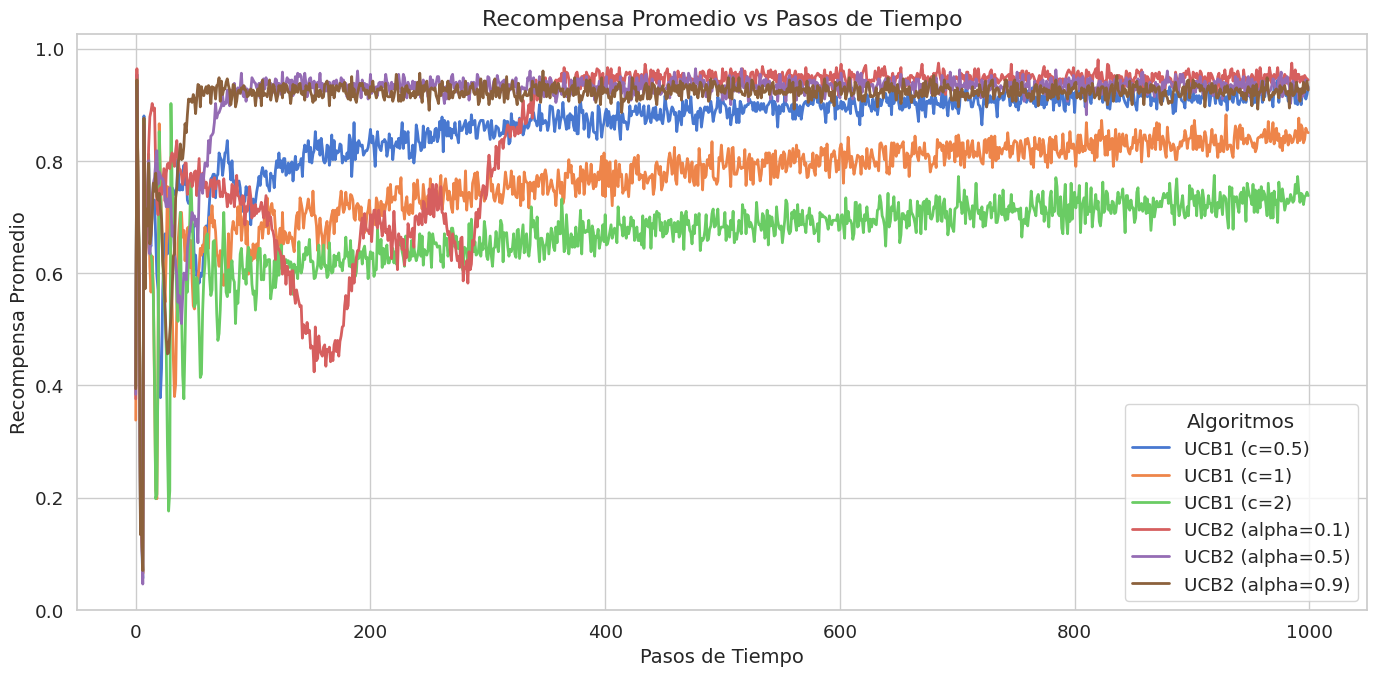

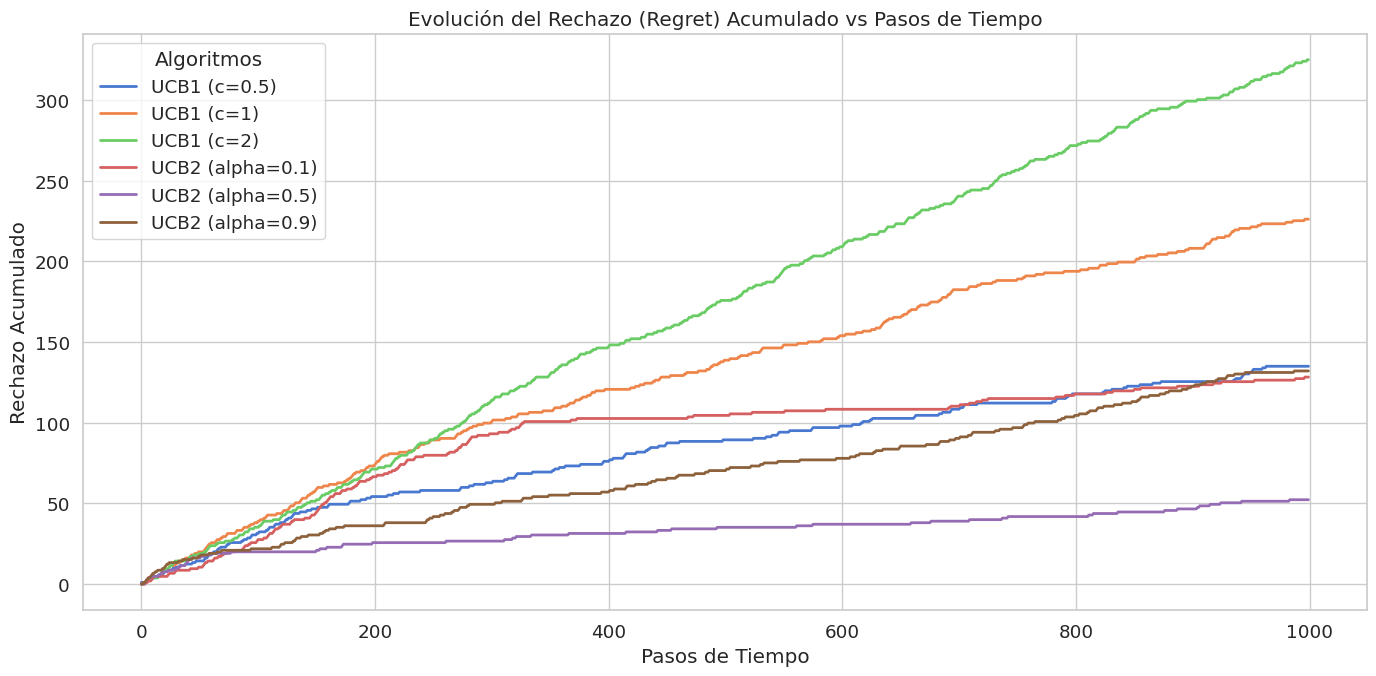


Evaluando UCB con brazos Binomial...
Bandit with 10 arms: ArmBinomial(n=10, p=0.74), ArmBinomial(n=10, p=0.25), ArmBinomial(n=10, p=0.69), ArmBinomial(n=10, p=0.05), ArmBinomial(n=10, p=0.80), ArmBinomial(n=10, p=0.03), ArmBinomial(n=10, p=0.11), ArmBinomial(n=10, p=0.03), ArmBinomial(n=10, p=0.40), ArmBinomial(n=10, p=0.36)
Optimal arm: 5 with expected reward=8.030830250059216

Resultados para Binomial:


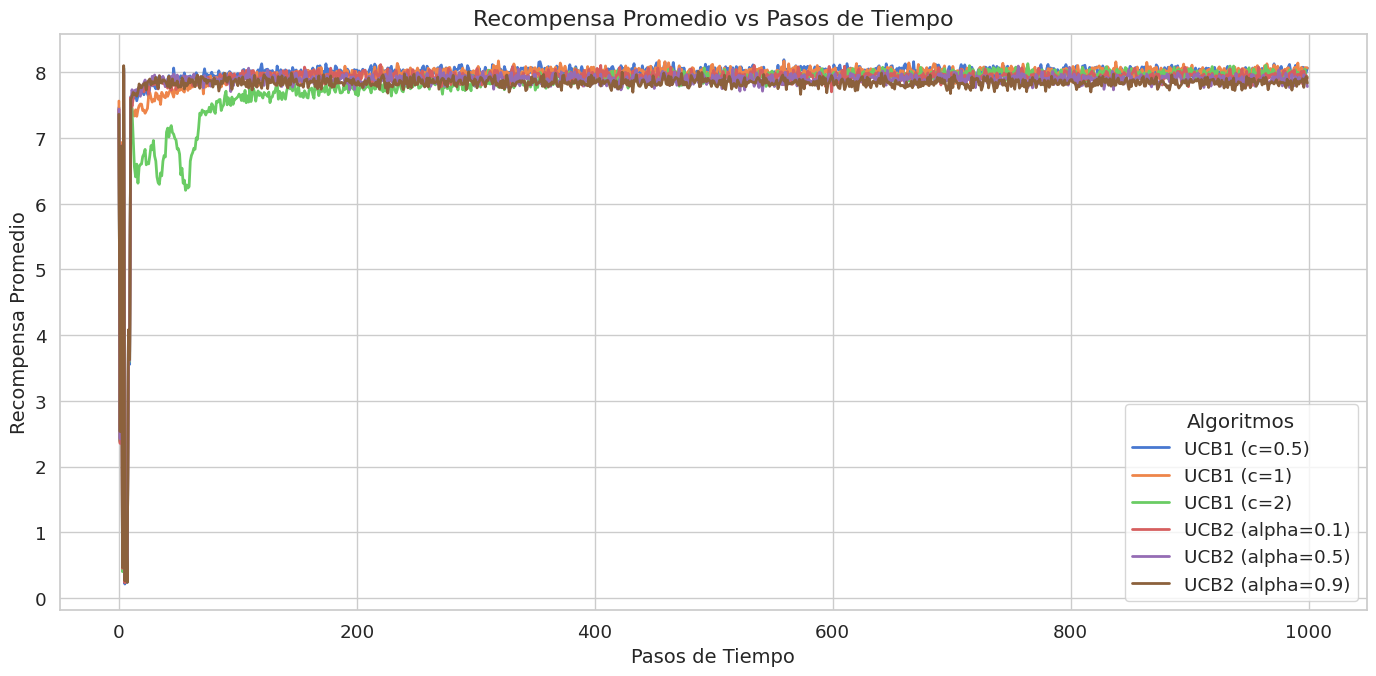

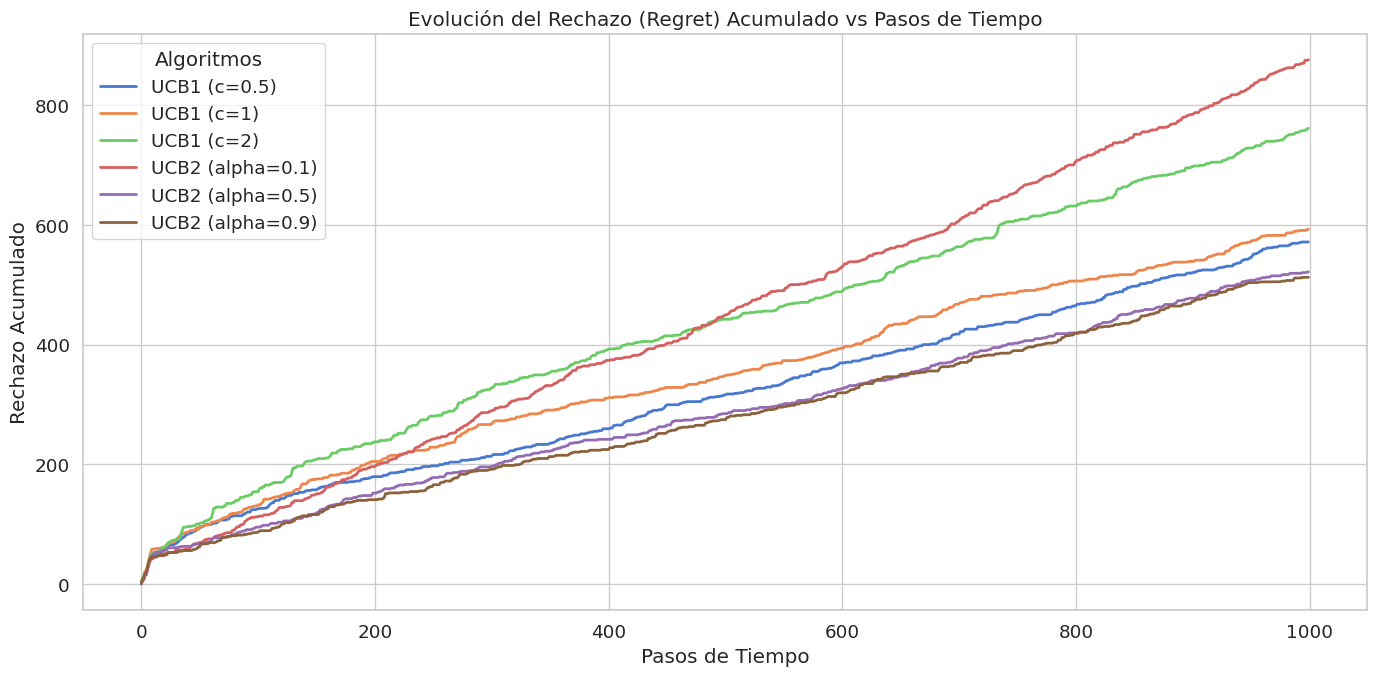


Evaluando UCB con brazos Normal...
Bandit with 10 arms: ArmNormal(mu=1.41, sigma=1.0), ArmNormal(mu=1.23, sigma=1.0), ArmNormal(mu=3.25, sigma=1.0), ArmNormal(mu=1.96, sigma=1.0), ArmNormal(mu=4.62, sigma=1.0), ArmNormal(mu=4.23, sigma=1.0), ArmNormal(mu=7.17, sigma=1.0), ArmNormal(mu=8.23, sigma=1.0), ArmNormal(mu=7.7, sigma=1.0), ArmNormal(mu=7.48, sigma=1.0)
Optimal arm: 8 with expected reward=8.23

Resultados para Normal:


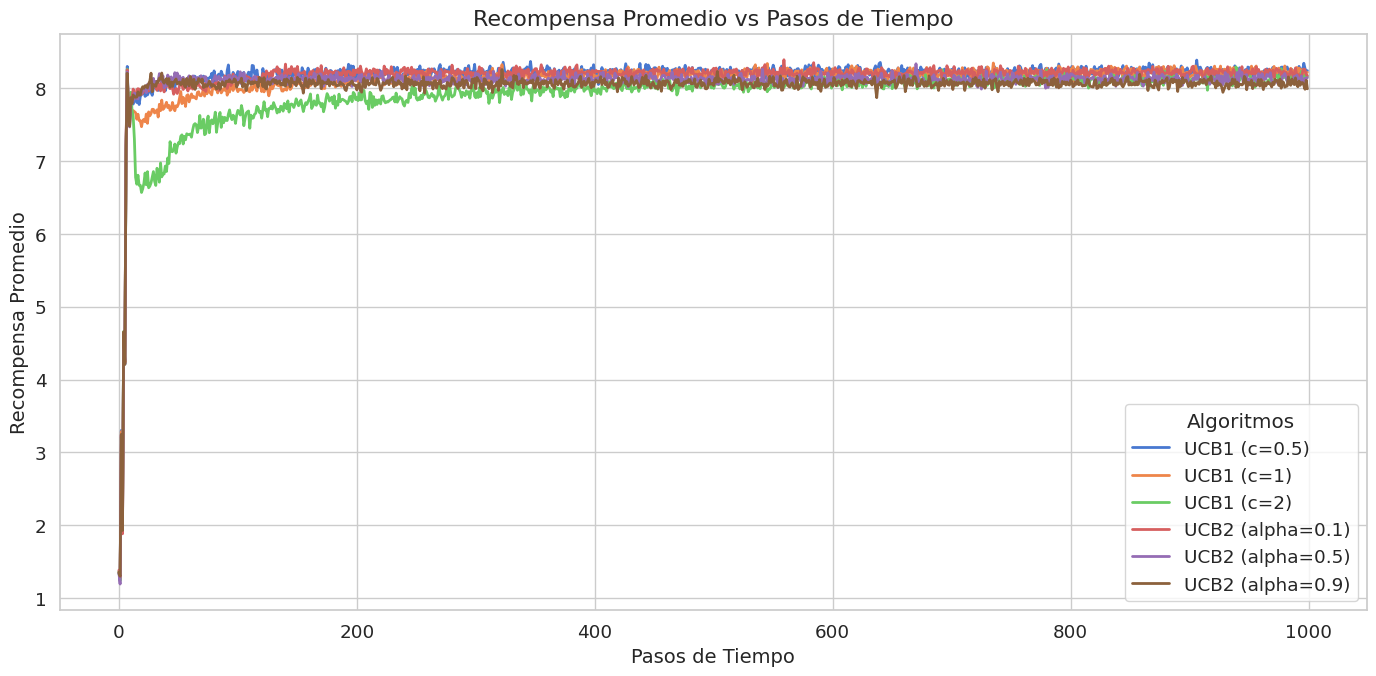

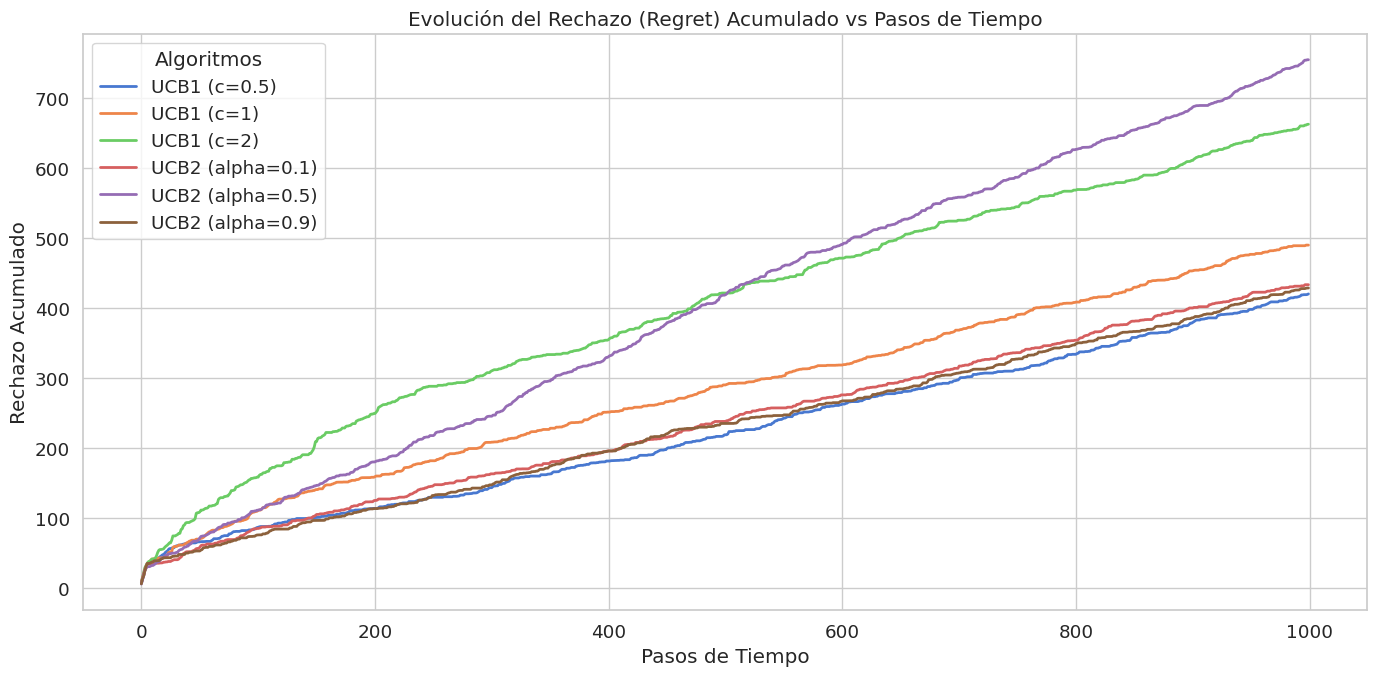

In [9]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Tipos de brazos que se van a utilizar en el experimento
arm_types = {
    'Bernoulli': ArmBernoulli,
    'Binomial': ArmBinomial,
    'Normal': ArmNormal
}

# Definir los hiperparámetros a comparar para cada algoritmo UCB
ucb1_configs = [0.5, 1, 2]  # Valores del parámetro 'c' en UCB1
ucb2_configs = [0.1, 0.5, 0.9]  # Valores del parámetro 'alpha' en UCB2

# Definir los algoritmos a comparar en la familia UCB con diferentes configuraciones
algorithms = []

# Añadir UCB1 con diferentes valores de 'c'
for c in ucb1_configs:
    algorithms.append(UCB1(k=k, c=c))

# Añadir UCB2 con diferentes valores de 'alpha'
for alpha in ucb2_configs:
    algorithms.append(UCB2(k=k, alpha=alpha))

# Bucle para evaluar cada tipo de brazo con los algoritmos definidos
for arm_name, ArmClass in arm_types.items():
    print(f"\nEvaluando UCB con brazos {arm_name}...")

    # Creación del bandit con el tipo de brazo correspondiente
    bandit = Bandit(arms=ArmClass.generate_arms(k))  # Generar un bandido con k brazos según la distribución del tipo de brazo actual
    print(bandit)

    # Obtener el brazo óptimo y su recompensa esperada
    optimal_arm = bandit.optimal_arm
    print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

    # Ejecutar el experimento
    rewards, optimal_selections, regret_accumulated, arm_stats = run_experiment(bandit, algorithms, steps, runs)

    # Graficar los resultados específicos para este tipo de brazo
    print(f"\nResultados para {arm_name}:")
    plot_average_rewards(steps, rewards, algorithms)
    plot_regret(steps, regret_accumulated, algorithms)
    #plot_optimal_selections(steps, optimal_selections, algorithms)  # Opcional
    # plot_arm_statistics(arm_stats, algorithms)  # Opcional


### Análisis detallado de las imágenes

La serie de gráficos generados permite analizar en profundidad el comportamiento de la **familia UCB** (UCB1 y UCB2) en un problema de **k-armed bandit**. Cada gráfica representa un aspecto clave del rendimiento de las diferentes configuraciones de hiperparámetros para estos algoritmos, evaluados con tres tipos de distribución en los brazos: **Bernoulli**, **Binomial** y **Normal**.

#### **1. Recompensa Promedio vs Pasos de Tiempo**

Este gráfico muestra la evolución de la recompensa promedio a lo largo del tiempo para las distintas configuraciones de UCB:

1. **UCB1 con diferentes valores de c (0.5, 1, 2)**:
   - **c=0.5 y c=1** muestran un **buen desempeño**, alcanzando rápidamente una recompensa promedio estable y cercana a la máxima posible.
   - **c=2** muestra una convergencia más tardía en todas las distribuciones, debido a su mayor exploración inicial.

2. **UCB2 con diferentes valores de alpha (0.1, 0.5, 0.9)**:
   - **alpha=0.9** es el que obtiene **mejores recompensas**, mostrando un equilibrio adecuado entre exploración y explotación.
   - **alpha=0.5** también tiene un buen rendimiento, aunque inferior a alpha=0.9 en **Normal y Binomial**.
   - **alpha=0.1** tiene un rendimiento bajo, siendo más conservador en la exploración, aunque bueno en **Normal**.

3. **Distribuciones**:
   - **Bernoulli**: Se observa que **UCB2(alpha=0.5)** y **UCB1(c=0.5)** obtienen las mejores recompensas, estabilizándose cerca de la recompensa óptima.
   - **Binomial**: El comportamiento es similar al de **Bernoulli**, con **UCB1(c=0.5)** y **UCB2(alpha=0.9)** destacando ligeramente.
   - **Normal**: **UCB1(c=0.5)** y **UCB2(alpha=0.9)** convergen mejor dentro de sus respectivos algoritmos.
   
#### **2. Evolución del Rechazo (Regret) Acumulado vs Pasos de Tiempo**

El regret acumulado mide **cuánto se pierde por no seleccionar el brazo óptimo en cada paso**:

1. **UCB1**:
   - **c=0.5** presenta **el menor regret acumulado** en todas las distribuciones, indicando que **logra encontrar el brazo óptimo rápidamente**.
   - **c=1** tiene un regret intermedio, mientras que **c=2** tiene **el peor desempeño** debido a su **excesiva exploración**.

2. **UCB2**:
   - **alpha=0.9** obtiene **el menor regret** en casi todos los casos, mostrando un **buen equilibrio** entre exploración y explotación.
   - **alpha=0.5** presenta un regret moderado, con un comportamiento estable.
   - **alpha=0.1** tiene el **peor regret acumulado**, ya que favorece demasiado la exploración y tarda más en converger al brazo óptimo.

3. **Distribuciones**:
   - **Bernoulli**: **UCB1(c=0.5)** y **UCB2(alpha=0.5)** tienen el menor regret.
   - **Binomial**: Comportamiento similar, aunque **UCB2(alpha=0.9)** se desempeña ligeramente mejor.
   - **Normal**: **UCB1(c=0.5)** y **UCB2(alpha=0.9)** muestran un buen rendimiento.

#### **3. Interpretación conjunta**

Los resultados muestran que **UCB1 con c=0.5** y **UCB2 con alpha=0.9** son, en general, **las configuraciones más equilibradas y eficaces**. La diferencia entre distribuciones no altera drásticamente el comportamiento relativo entre los algoritmos, pero en **distribuciones Bernoulli y Binomial**, **UCB2(alpha=0.9)** resulta **especialmente competitivo**.

En **distribuciones Normales**, **UCB1(c=0.5)** parece **ser más robusto**, probablemente porque **la estimación de las recompensas es más precisa debido a la naturaleza continua de la Normal**, lo que reduce la necesidad de estrategias adaptativas como UCB2.

---

## Conclusiones Finales

#### **1. Exploración vs Explotación en UCB**

El parámetro **c** en **UCB1** y **alpha** en **UCB2** regulan el equilibrio entre exploración y explotación:
- **Valores bajos de c (UCB1)** y **alpha altos (UCB2)** tienden a favorecer **una explotación más rápida** tras una fase inicial de exploración.
- **Valores altos de c (UCB1)** y **alpha bajos (UCB2)** favorecen **más exploración**, pero pueden **retrasar innecesariamente la identificación del brazo óptimo**.

#### **2. Impacto de los Hiperparámetros**

- **UCB1(c=0.5)** y **UCB2(alpha=0.9)** son, en general, **las configuraciones que mejor equilibran exploración y explotación**.
- **UCB1(c=2)** y **UCB2(alpha=0.1)** tienden a **explorar demasiado**, lo que se traduce en **mayores regrets**.

#### **3. Regret Acumulado como métrica clave**

El **regret acumulado** sigue siendo **la métrica más importante**:
- Es **esencial para evaluar el costo de no elegir el brazo óptimo**.
- Permite **comparar algoritmos a largo plazo**, mostrando **cuál logra minimizar las pérdidas**.

#### **4. Influencia de la Distribución de los Brazos**

- **Bernoulli** y **Binomial** presentan **patrones similares**, con **UCB2(alpha=0.9)** mostrando **un rendimiento destacable**.
- **Normal** favorece ligeramente **UCB1(c=0.5)**, probablemente **debido a la estabilidad de las recompensas continuas**.

---

**Conclusión general:**  
**El ajuste adecuado de los hiperparámetros es esencial para que UCB1 y UCB2 equilibren exploración y explotación, maximizando el rendimiento en entornos inciertos.**
